**PART 1**

**Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.**

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:01<00:00, 16622540.49it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 305011.92it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5541164.32it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 896800.97it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



**Step2. Train the GAN model to produce images in this new domain**

In [2]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


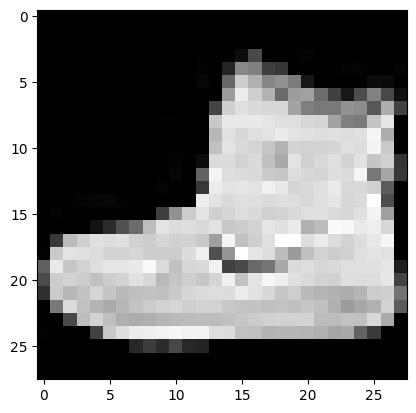

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

**Dataloader to load images in batches**

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([8, 7, 7, 4, 9, 0, 2, 6, 5, 5, 0, 5, 4, 7, 1, 5, 4, 9, 3, 8, 2, 0, 3, 9,
        4, 0, 9, 2, 2, 1, 0, 8, 4, 6, 8, 7, 1, 7, 9, 4, 1, 3, 8, 3, 4, 9, 9, 3,
        7, 1, 4, 8, 3, 6, 4, 6, 6, 3, 0, 1, 5, 9, 6, 7, 4, 7, 8, 1, 4, 7, 0, 7,
        6, 7, 2, 8, 7, 9, 2, 4, 6, 3, 6, 0, 8, 8, 6, 5, 8, 2, 2, 3, 9, 9, 1, 7,
        6, 9, 6, 2])


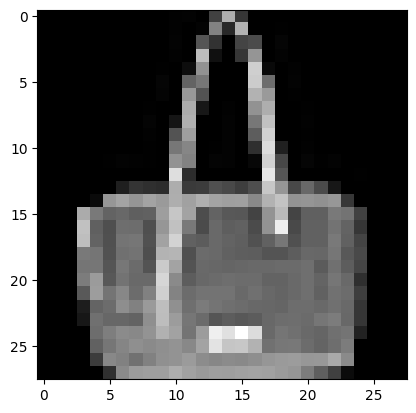

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cpu')

**Discriminator Network**

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [11]:
D.to(device);

**Generator Network**

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

**TanH as activation function for Generator**

In [14]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

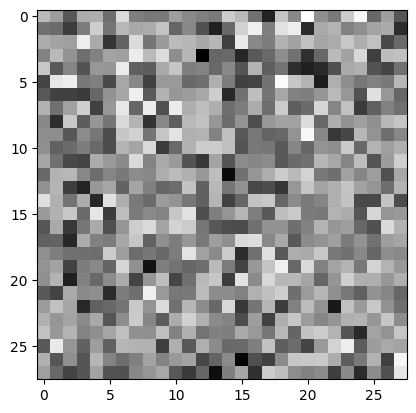

In [15]:
plt.imshow(gen_imgs[0], cmap='gray');

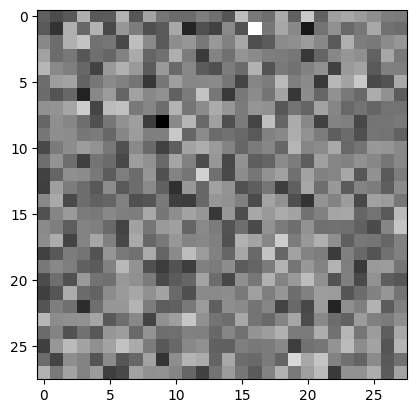

In [16]:
plt.imshow(gen_imgs[1], cmap='gray');

In [17]:
G.to(device);


**Discriminator Training**

In [18]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [19]:
# helper function to reset gradients and train the discriminator

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

**Generator Training**

In [20]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

**Training the model**

In [22]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

**Let's save a batch of real images that we can use for visual comparision while looking at the generated images.**

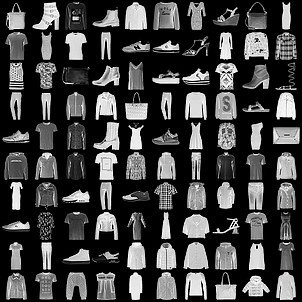

In [23]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

**We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.**

Saving fake_images-0000.png


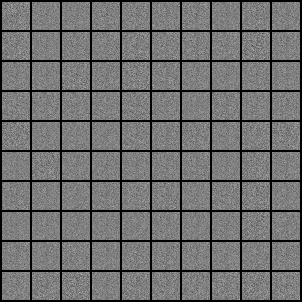

In [24]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator.

In [25]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0613, g_loss: 4.1013, D(x): 0.99, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.0979, g_loss: 5.9291, D(x): 0.97, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.0158, g_loss: 5.9060, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0695, g_loss: 4.5257, D(x): 0.99, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.0880, g_loss: 4.3866, D(x): 0.97, D(G(z)): 0.05
Epoch [1/300], Step [600/600], d_loss: 0.0365, g_loss: 5.5499, D(x): 0.98, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0308, g_loss: 5.2332, D(x): 0.99, D(G(z)): 0.01
Epoch [2/300], Step [400/600], d_loss: 0.0524, g_loss: 7.6528, D(x): 0.97, D(G(z)): 0.00
Epoch [2/300], Step [600/600], d_loss: 0.0174, g_loss: 7.1387, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1058, g_loss: 5.2557, D(x): 0.98, D(G(z)): 0.06
Epoch [3/300], Step [400/6

**Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.**

In [26]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

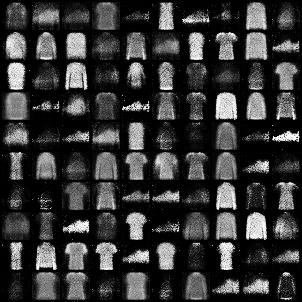

In [27]:
Image('./samples/fake_images-0025.png')

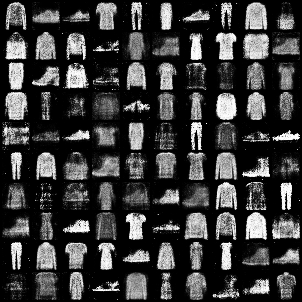

In [28]:
Image('./samples/fake_images-0100.png')

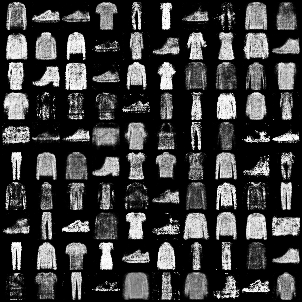

In [29]:
Image('./samples/fake_images-0200.png')

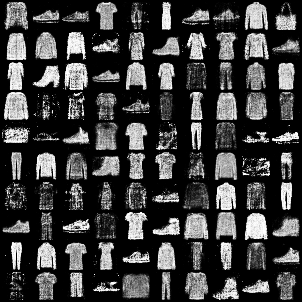

In [30]:
Image('./samples/fake_images-0300.png')

I did not face any issue during the process.Everything went smooth

In [94]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

Visualising the loss changes overtime. For GANs we expect the generators lloss to reduce overtime, without the discriminator loss getting too high

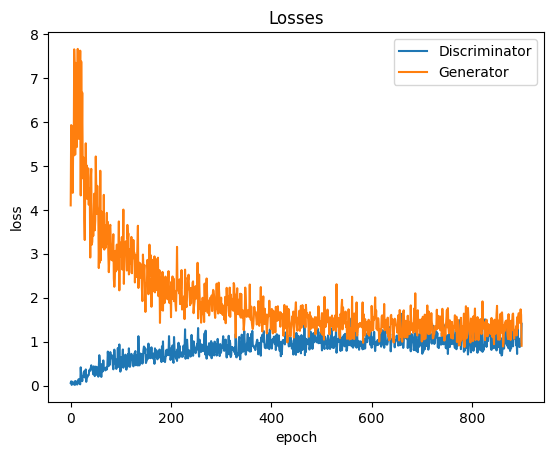

In [32]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

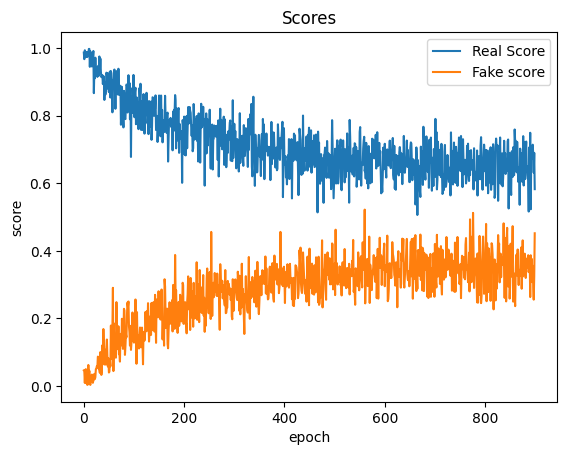

In [33]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

**Step4. Save the model weights in the folder to be used later.**

In [34]:
torch.save(G.state_dict(), 'generator_weights.pth')
torch.save(D.state_dict(), 'discriminator_weights.pth')

**# Step 5: Load the model using the saved weights**

In [35]:
G.load_state_dict(torch.load('generator_weights.pth'))
G.eval()

D.load_state_dict(torch.load('discriminator_weights.pth'))
D.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

**Step6:Re-train the GAN model to see if you can improve**

In [36]:
%%time

num_epochs = 300
total_step = len(data_loader)
re_d_losses, re_g_losses, re_real_scores, re_fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()


        # Inspect the losses
        if (i+1) % 200 == 0:
            re_d_losses.append(d_loss.item())
            re_g_losses.append(g_loss.item())
            re_real_scores.append(real_score.mean().item())
            re_fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.7199, g_loss: 1.5818, D(x): 0.71, D(G(z)): 0.27
Epoch [0/300], Step [400/600], d_loss: 1.1996, g_loss: 1.2075, D(x): 0.62, D(G(z)): 0.41
Epoch [0/300], Step [600/600], d_loss: 1.2137, g_loss: 1.1433, D(x): 0.63, D(G(z)): 0.41
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.9110, g_loss: 1.7142, D(x): 0.64, D(G(z)): 0.27
Epoch [1/300], Step [400/600], d_loss: 1.0074, g_loss: 1.4013, D(x): 0.63, D(G(z)): 0.30
Epoch [1/300], Step [600/600], d_loss: 0.9618, g_loss: 1.8719, D(x): 0.63, D(G(z)): 0.24
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.8994, g_loss: 1.2037, D(x): 0.70, D(G(z)): 0.33
Epoch [2/300], Step [400/600], d_loss: 0.9450, g_loss: 1.5108, D(x): 0.64, D(G(z)): 0.31
Epoch [2/300], Step [600/600], d_loss: 0.8966, g_loss: 1.4794, D(x): 0.67, D(G(z)): 0.29
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.1159, g_loss: 1.5308, D(x): 0.65, D(G(z)): 0.37
Epoch [3/300], Step [400/6

**Step 7: Save the model weights without using checkpoints**


In [37]:
torch.save(G.state_dict(), 'generator_weights_final.pth')
torch.save(D.state_dict(), 'discriminator_weights_final.pth')

**Step 8: Load the model weights without using checkpoints**

In [38]:
G.load_state_dict(torch.load('generator_weights_final.pth'))
G.eval()

D.load_state_dict(torch.load('discriminator_weights_final.pth'))
D.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

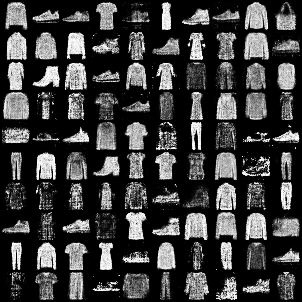

In [90]:
Image('./samples/fake_images-0025.png')

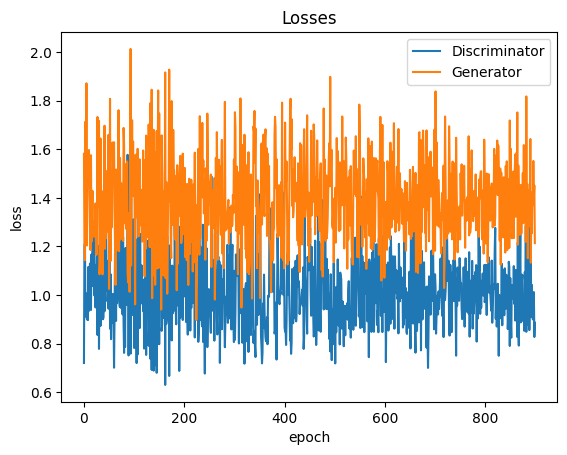

In [91]:
plt.plot(re_d_losses, '-')
plt.plot(re_g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

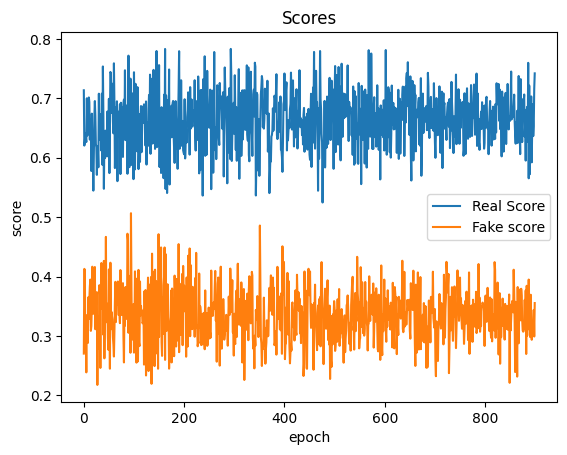

In [92]:
plt.plot(re_real_scores, '-')
plt.plot(re_fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');